In [13]:
from sklearn.datasets import fetch_california_housing
import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy.stats import randint as sp_randint
import seaborn as sns
sns.set_context('talk')


In [14]:

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")



In [15]:
housing = fetch_california_housing()
X = housing.data
y = housing.target
print(housing.DESCR)


.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

rf = RandomForestRegressor(n_estimators=100, 
                           max_features=10, 
                           min_samples_split=2,
                           random_state=10)
score = cross_val_score(rf,X,y,cv = 5) #WARNING: THE SCORE HERE IS THE COEF OF DETERMINATION (GREATER IS BETTER)
print('score: mean={:.2f} ; std={:.3f}'\
      .format(score.mean(),score.std()))
    
rf.fit(X,y)


score: mean=0.65 ; std=0.084


RandomForestRegressor(max_features=10, random_state=10)

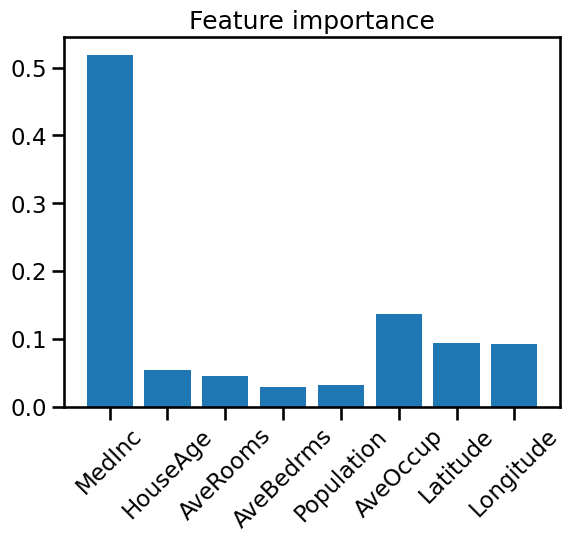

In [17]:
plt.bar(np.arange(0,len(housing.feature_names)),rf.feature_importances_)
plt.xticks(ticks=np.arange(0,len(housing.feature_names)),labels=housing.feature_names, rotation=45);
plt.title('Feature importance')
plt.savefig('../fig/L2/importance_RF.png')

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators' : [100,400,700,1000],
    'max_features' : [1,8,13],
    'min_samples_split' : [2,5,10]
}
clf = GridSearchCV(rf, param_grid, cv=5, verbose=2,n_jobs=4)

clf.fit(X,y)
print('GridSearch finished')

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/julaja/miniconda3/envs/MAT330/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))


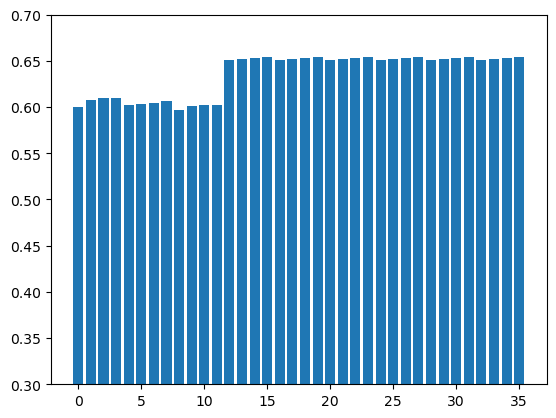

In [15]:
plt.bar(range(len(means)),means)
plt.ylim(.3,.7)
plt.show()

In [16]:
report(clf.cv_results_)

Model with rank: 1
Mean validation score: 0.654 (std: 0.080)
Parameters: {'max_features': 8, 'min_samples_split': 5, 'n_estimators': 1000}

Model with rank: 1
Mean validation score: 0.654 (std: 0.080)
Parameters: {'max_features': 13, 'min_samples_split': 5, 'n_estimators': 1000}

Model with rank: 3
Mean validation score: 0.654 (std: 0.079)
Parameters: {'max_features': 8, 'min_samples_split': 10, 'n_estimators': 1000}

Model with rank: 3
Mean validation score: 0.654 (std: 0.079)
Parameters: {'max_features': 13, 'min_samples_split': 10, 'n_estimators': 1000}



In [17]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'n_estimators' : [100,400,700,1000],
    'max_features' : sp_randint(1,13),
    'min_samples_split' : sp_randint(2,10)
}
clf = RandomizedSearchCV(rf, param_dist, cv=5, n_iter=15, 
                         verbose=1,n_jobs=4, random_state=1)

clf.fit(X,y)
print('Random finished')


Fitting 5 folds for each of 15 candidates, totalling 75 fits


/Users/julaja/miniconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Random finished


In [18]:
report(clf.cv_results_)

Model with rank: 1
Mean validation score: 0.658 (std: 0.074)
Parameters: {'max_features': 7, 'min_samples_split': 3, 'n_estimators': 700}

Model with rank: 2
Mean validation score: 0.657 (std: 0.075)
Parameters: {'max_features': 7, 'min_samples_split': 3, 'n_estimators': 400}

Model with rank: 3
Mean validation score: 0.657 (std: 0.076)
Parameters: {'max_features': 5, 'min_samples_split': 8, 'n_estimators': 400}



In [33]:
from hyperopt import tpe, hp, fmin, space_eval

#Define the objective function to minimize
def objective(params):
    n_estimators, max_features, min_samples_split = params['n_estimators'], params['max_features'], params['min_samples_split']
    rf = RandomForestRegressor(n_estimators=n_estimators, 
                           max_features=max_features, 
                           min_samples_split=min_samples_split,
                           random_state=10)
    score = cross_val_score(rf,X,y,cv = 5)

    return -score.mean()

In [31]:
space = {
    'n_estimators': hp.choice('n_estimators',[100,400,700,1000]),
    'max_features': hp.randint('max_features',1,13),
    'min_samples_split' : hp.randint('min_samples_split',2,10)
}

In [45]:
best = fmin(
    fn=objective, # Objective Function to optimize
    space=space, # Hyperparameter's Search Space
    algo=tpe.suggest, # Optimization algorithm (representative TPE)
    max_evals=10 # Number of optimization attempts
)
print(space_eval(space,best))

100%|██████████| 10/10 [00:45<00:00,  4.57s/trial, best loss: -0.670093703896406]
{'max_features': 8, 'min_samples_split': 3, 'n_estimators': 1000}


In [46]:
print(space_eval(space,best))

{'max_features': 8, 'min_samples_split': 3, 'n_estimators': 1000}
